In [1]:
%matplotlib inline

from joblib import load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pipeline = load('pipeline.joblib')
history = pd.read_csv('lending-club.csv')
X = history.drop(columns='Interest Rate')
y_pred_log = pipeline.predict(X)
y_pred = np.expm1(y_pred_log)

[01:08:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [104]:
from tqdm import tnrange

def partial_dependence(estimator, X, feature, percentiles=(5, 95), grid_resolution=100):
    X = X.copy()
    
    start_percentile, stop_percentile = percentiles
    grid = np.linspace(start=np.percentile(X[feature], start_percentile), 
                       stop=np.percentile(X[feature], stop_percentile), 
                       num=grid_resolution)
    
    y_pred = np.empty(grid_resolution)
    for i in tnrange(grid_resolution):
        X[feature] = grid[i]
        y_pred[i] = np.average(estimator.predict(X))
    
    return grid, y_pred

In [105]:
encoder = pipeline.named_steps['onehotencoder']
model = pipeline.named_steps['xgbregressor']

In [106]:
X_encoded = encoder.transform(X)

In [107]:
X_encoded.columns

Index(['Annual Income', 'Credit Score', 'Loan Amount',
       'Loan Purpose_Home improvement', 'Loan Purpose_Credit card refinancing',
       'Loan Purpose_Debt consolidation', 'Loan Purpose_Medical expenses',
       'Loan Purpose_Other', 'Loan Purpose_Car financing',
       'Loan Purpose_Major purchase', 'Loan Purpose_Business',
       'Loan Purpose_Home buying', 'Loan Purpose_Moving and relocation',
       'Loan Purpose_Vacation', 'Loan Purpose_Green loan', 'Monthly Debts'],
      dtype='object')

In [114]:
feature = 'Annual Income'
grid, y_pred_log = partial_dependence(model, X_encoded, feature)
y_pred = np.expm1(y_pred_log)

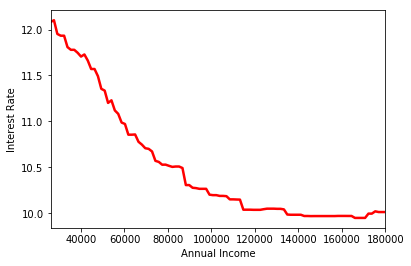

In [117]:
y = history['Interest Rate']
plt.plot(grid, y_pred, '-', color='red', linewidth=2.5)
# plt.plot(X, y, 'o', color='grey', alpha=0.01)
plt.xlim(min(grid), max(grid))
plt.xlabel(feature)
plt.ylabel(y.name)
plt.show()

In [128]:
from tqdm import tnrange

def partial_dependence_interact(estimator, X, feature1, feature2, percentiles=(5, 95), grid_resolution=100):
    X = X.copy()
    
    start_percentile, stop_percentile = percentiles
    x = np.linspace(start=np.percentile(X[feature1], start_percentile), 
                    stop=np.percentile(X[feature1], stop_percentile), 
                    num=grid_resolution)
    
    y = np.linspace(start=np.percentile(X[feature2], start_percentile), 
                    stop=np.percentile(X[feature2], stop_percentile), 
                    num=grid_resolution)
    
    z = np.empty((grid_resolution, grid_resolution))
    for i in tnrange(grid_resolution):
        for j in tnrange(grid_resolution):
            X[feature1] = x[i]
            X[feature2] = y[j]
            z[i, j] = np.average(estimator.predict(X))
    
    return x, y, z

In [129]:
x, y, z = partial_dependence_interact(model, X_encoded, 'Annual Income', 'Credit Score')

KeyboardInterrupt: 

In [118]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [125]:
import pandas as pd
import plotly.graph_objs as go

# Read data from a csv
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')

data = [
    go.Surface(
        z=z_data.values, 
        x=list(range(25,50)), 
        y=list(range(100,125))
    )
]
layout = go.Layout(
    title='Mt Bruno Elevation',
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='elevations-3d-surface')

In [121]:
z_data

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,0,27.809850,49.619360,83.080670,116.66320,130.41400,150.72060,220.18710,156.15360,148.64160,...,49.961420,21.89279,17.025520,11.743170,14.752260,13.667100,5.677561,3.312340,1.156517,-0.147662
1,1,27.719660,48.550220,65.213740,95.27666,116.99640,133.90560,152.34120,151.93400,160.11390,...,33.088710,38.40972,44.248430,69.578600,4.019351,3.050024,3.039719,2.996142,2.967954,1.999594
2,2,30.426700,33.477520,44.809530,62.47495,77.43523,104.21530,102.73930,137.00040,186.07060,...,48.471320,74.71461,60.090900,7.073525,6.089851,6.537450,6.666096,7.306965,5.736840,3.625628
3,3,16.665490,30.108600,39.969520,44.12225,59.57512,77.56929,106.89250,166.55390,175.23810,...,60.559160,55.92124,15.172840,8.248324,36.680870,61.934130,20.268670,68.588190,46.498120,0.236009
4,4,8.815617,18.351600,8.658275,27.58590,48.62691,60.18013,91.32860,145.71090,116.06530,...,47.426910,69.20731,44.954680,29.171970,17.916740,16.255150,14.655590,17.260480,31.222450,46.717040
5,5,6.628881,10.413390,24.819390,26.08952,30.16050,52.30802,64.71007,76.30823,84.63686,...,140.264700,81.26501,56.457560,30.421640,17.287820,8.302431,2.981626,2.698536,5.886086,5.268358
6,6,21.839750,6.639270,18.970850,32.89204,43.15014,62.86014,104.66570,130.22940,114.84940,...,122.422100,123.96980,109.095200,98.419560,77.613740,32.490310,14.673440,7.370775,0.037110,0.642339
7,7,53.343030,26.797970,6.639270,10.88787,17.20440,56.18116,79.70141,90.84530,98.27675,...,68.174900,46.24076,39.938570,31.216530,36.883350,40.025250,117.429700,12.703280,1.729771,0.000000
8,8,25.667850,63.057170,22.141400,17.07400,41.74483,60.27227,81.42432,114.44400,102.32340,...,59.193550,42.47175,14.635980,6.944074,6.944075,27.749360,0.000000,0.000000,0.094494,0.077323
9,9,12.827000,69.205540,46.762930,13.96517,33.88744,61.82613,84.74799,121.12200,145.27410,...,79.344250,25.93483,6.944074,6.944074,6.944075,7.553681,0.000000,0.000000,0.000000,0.000000


In [122]:
help(go.Surface)

Help on class Surface in module plotly.graph_objs:

class Surface(plotly.basedatatypes.BaseTraceType)
 |  Surface(arg=None, autocolorscale=None, cauto=None, cmax=None, cmid=None, cmin=None, coloraxis=None, colorbar=None, colorscale=None, connectgaps=None, contours=None, customdata=None, customdatasrc=None, hidesurface=None, hoverinfo=None, hoverinfosrc=None, hoverlabel=None, hovertemplate=None, hovertemplatesrc=None, hovertext=None, hovertextsrc=None, ids=None, idssrc=None, lighting=None, lightposition=None, meta=None, metasrc=None, name=None, opacity=None, reversescale=None, scene=None, showscale=None, stream=None, surfacecolor=None, surfacecolorsrc=None, text=None, textsrc=None, uid=None, uirevision=None, visible=None, x=None, xcalendar=None, xsrc=None, y=None, ycalendar=None, ysrc=None, z=None, zcalendar=None, zsrc=None, **kwargs)
 |  
 |  Base class for the all trace types.
 |  
 |  Specific trace type classes (Scatter, Bar, etc.) are code generated as
 |  subclasses of this class.